In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [2]:
!nvidia-smi

Wed Dec 14 12:10:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   29C    P8     9W / 250W |    104MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P6000        Off  | 00000000:81:00.0 Off |                  Off |
| 26%   

In [3]:
# !pip install -q -U watermark
# !pip install -qq transformers
# # Update libraries
# !pip install seaborn==0.9.0
# !pip install sklearn
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
df =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/Tweets_Spring_Summer_2021_coded.csv',
                lineterminator='\n',
                skipinitialspace=True,
                usecols= ['Tweet', 'Substance', 'Use', 'Intent']
                )
# df

In [7]:
df = df.dropna(subset=['Substance'])
df = df.dropna(subset=['Use'])
df = df.dropna(subset=['Intent'])

In [8]:
# df.loc[df['Substance']=='CD']
# df.loc[df['Intent']=='N']
# df.loc[df['Use']=='H']
# df.loc[df['Use']=='U']

# Labeling Substance Column

In [9]:
substance_class_names = { 'D': 'Multiple identified specific substances', 
               'A':'Alcohol',
               'M':'Marijuana',
               'T':'Tobacco',
               'V':'Vape', 
               'C':'Cocaine',
               'G':'Indeterminiate and or generic dec indicative of substance type(s)',
               'H':'Heroine',
               'Rx':'Prescription and or pharmaceutical substances used appropriately and or misused ',
               'Ox':'Non-prescription and over-the-counter substances misused or abused (Typical) ',
               'P': 'Psychedelics and hallucinogens ',
               'Mx':'Methamphetamine',
               'CD':'Club drugs',
               'O':'Other substances used for substance misuse (Atypical) ',
               'X':'Unclear'
              }
use_class_names = { 'S': 'Specific information about substance use', 
               'N':'Non-specific information about substance use',
               'X':'Not specific or non-specific substance use',
               'U': '*****',
               'H': '*****'
              }
intent_class_names = { 'A': 'Active/recent active use', 
               'H':'Historical use',
               'I':'Intent to use',
               'X': 'Not active, historical, intent',
                'N' : '****'
              }

In [10]:
intent_possible_labels = df.Intent.unique()
use_possible_labels = df.Use.unique()
substance_possible_labels = df.Substance.unique()

0 X Unclear
1 A Alcohol
2 D Multiple identified specific substances
3 M Marijuana
4 G Indeterminiate and or generic dec indicative of substance type(s)
5 T Tobacco
6 Rx Prescription and or pharmaceutical substances used appropriately and or misused 
7 H Heroine
8 C Cocaine
9 O Other substances used for substance misuse (Atypical) 
10 V Vape
11 Mx Methamphetamine
12 CD Club drugs
13 Ox Non-prescription and over-the-counter substances misused or abused (Typical) 
14 P Psychedelics and hallucinogens 


Text(0.5, 0, 'Substance Types')

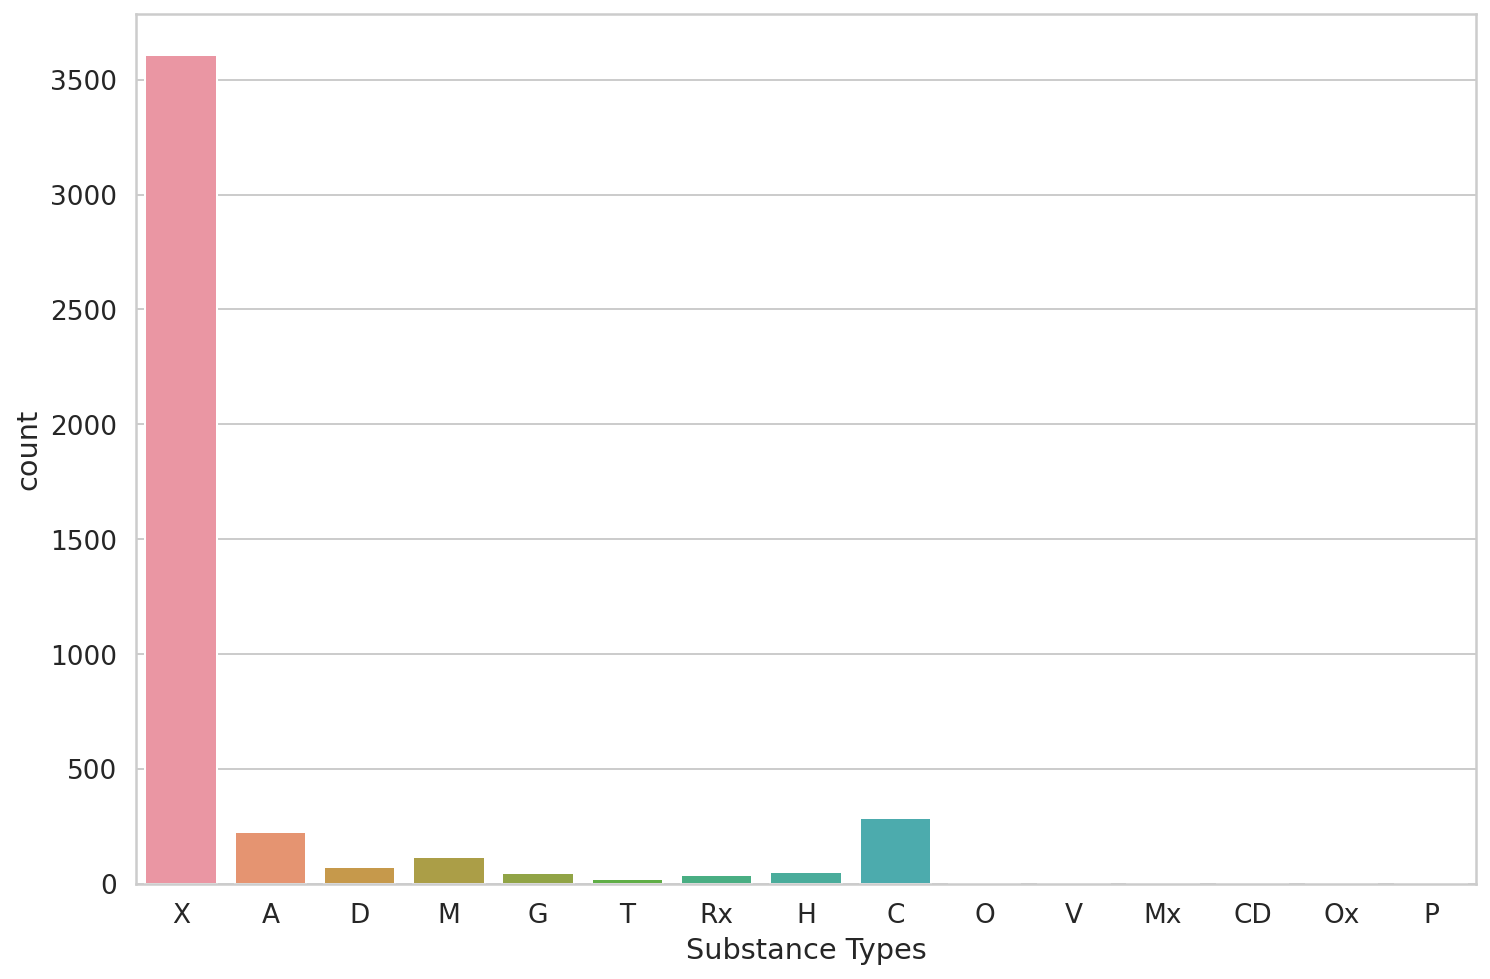

In [11]:
substance_label_dict = {}
for index, possible_label in enumerate(substance_possible_labels):
    substance_label_dict[possible_label] = index
for e in substance_label_dict.keys():
    print(substance_label_dict[e], e, substance_class_names[e])
sns.countplot(df.Substance)
plt.xlabel('Substance Types')

0 X Not specific or non-specific substance use
1 S Specific information about substance use
2 N Non-specific information about substance use
3 U *****
4 H *****


Text(0.5, 0, 'Substance Use')

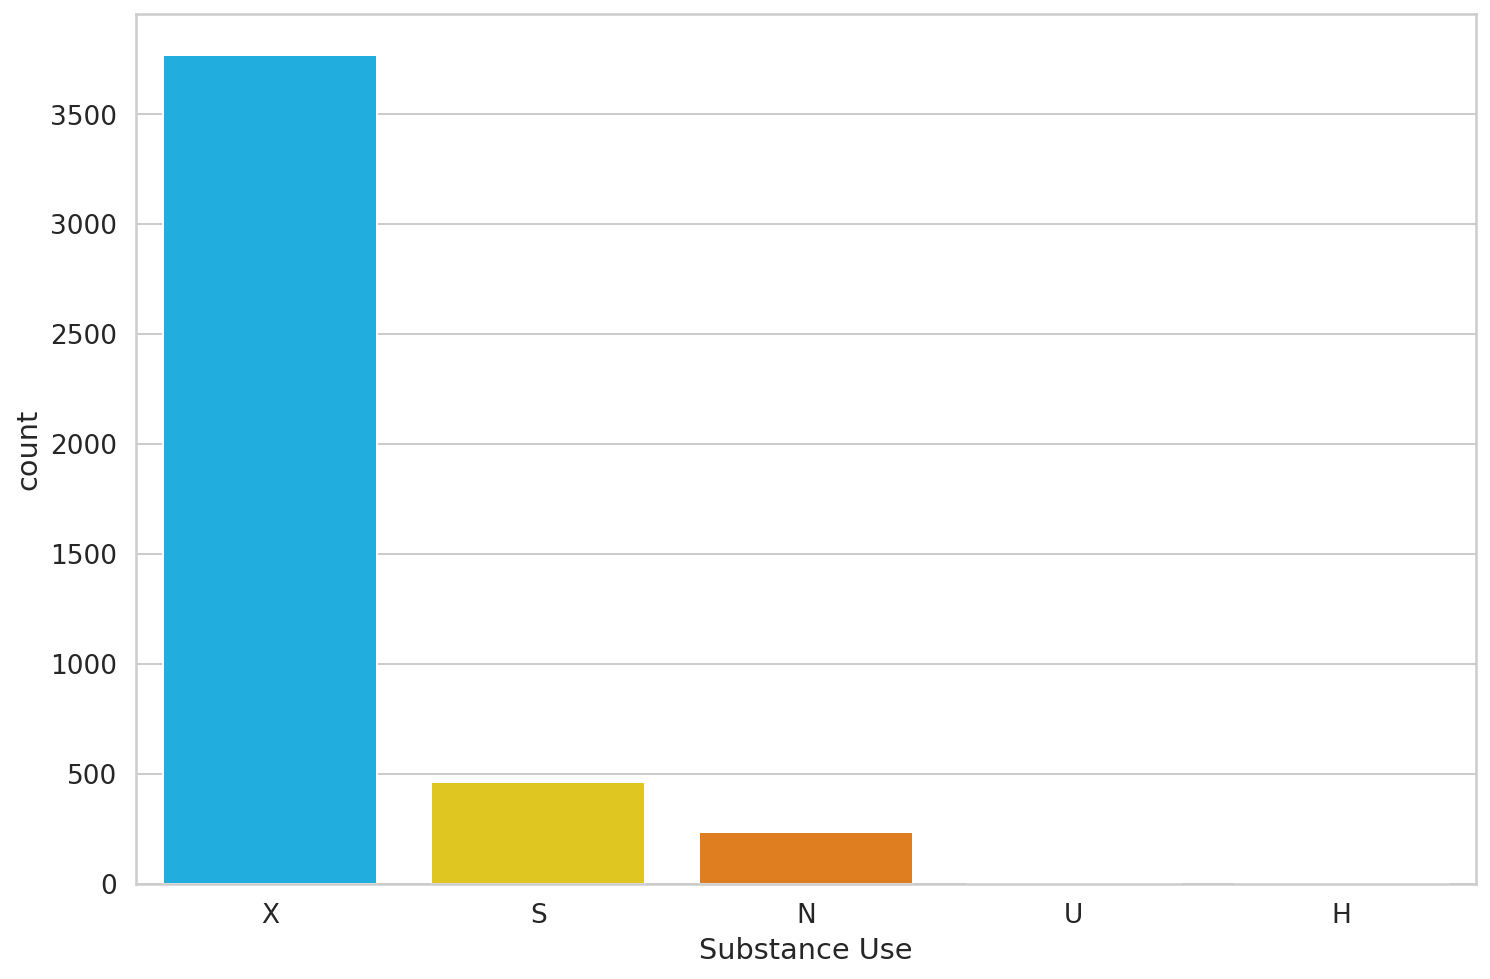

In [12]:
use_label_dict = {}
for index, possible_label in enumerate(use_possible_labels):
    use_label_dict[possible_label] = index
for e in use_label_dict.keys():
    print(use_label_dict[e], e, use_class_names[e])
sns.countplot(df.Use)
plt.xlabel('Substance Use')

0 X Not active, historical, intent
1 A Active/recent active use
2 I Intent to use
3 H Historical use
4 N ****


Text(0.5, 0, 'Intent')

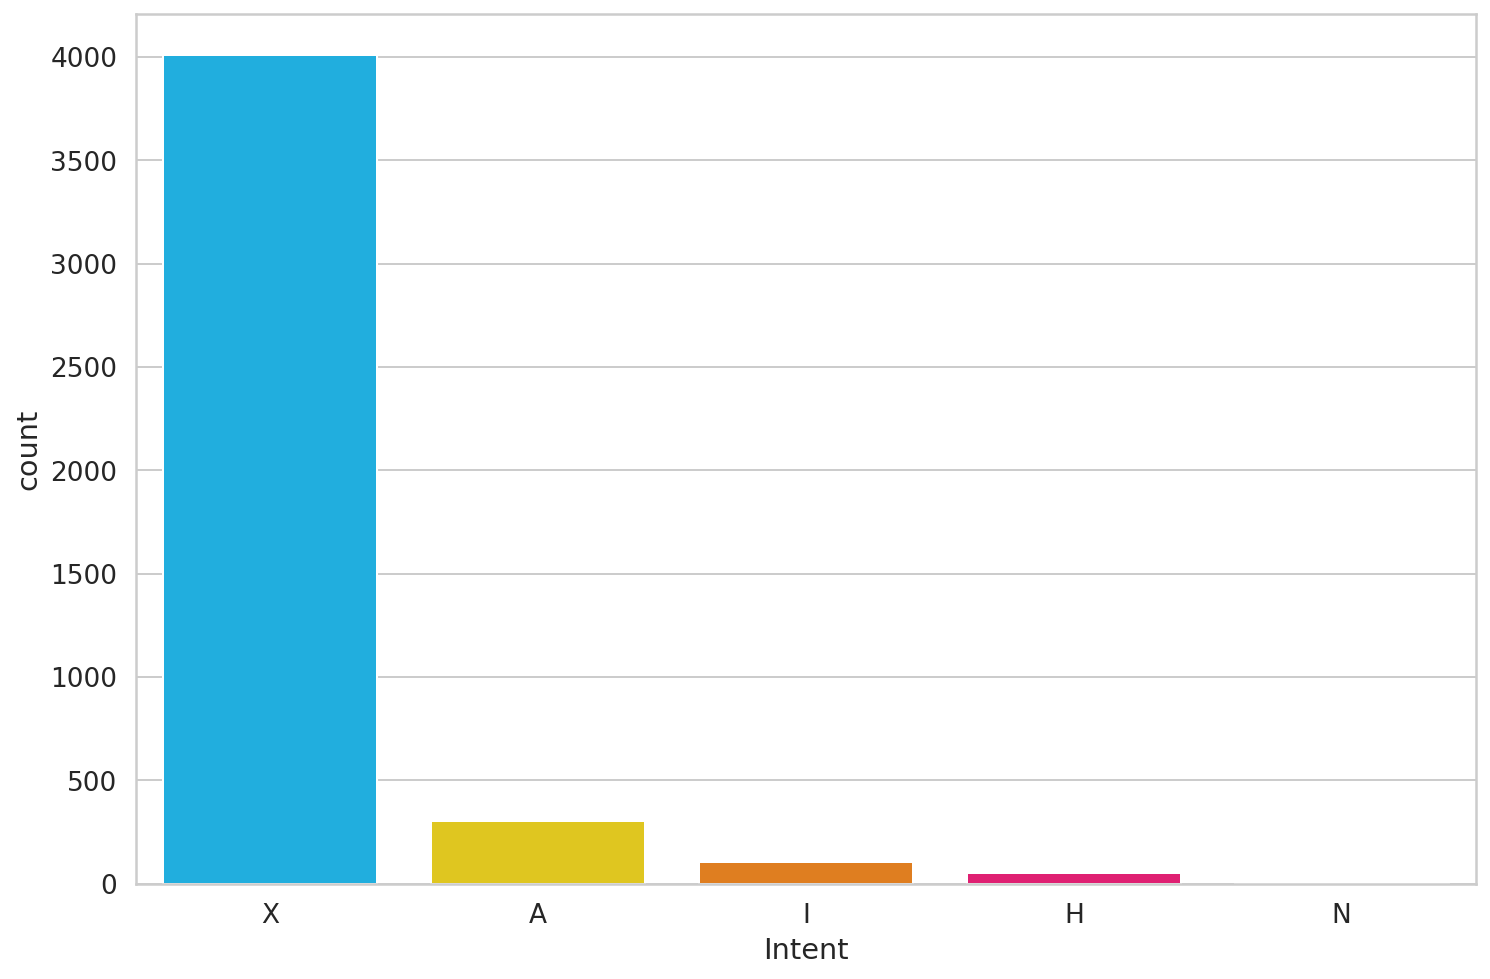

In [13]:
intent_label_dict = {}
for index, possible_label in enumerate(intent_possible_labels):
    intent_label_dict[possible_label] = index
for e in intent_label_dict.keys():
    print(intent_label_dict[e], e, intent_class_names[e])
sns.countplot(df.Intent)
plt.xlabel('Intent')

In [14]:
# df['Intent'] = df['Intent'].replace(np.nan, 'N')
df = df.dropna(subset=['Intent'])

In [15]:
# new_df= df['Tweet']
df2= df.replace({'Substance':substance_label_dict, 'Use': use_label_dict, 'Intent':intent_label_dict })

# df['Type_label'] = df.Substance.replace(substance_label_dict)
# df['Use_label'] = df.Use.replace(use_label_dict)
# df['Intent_label'] = df.Intent.replace(intent_label_dict)
# df['Intent_label'] = df['Intent_label'].apply(np.int64)

df2.tail(10)

,Tweet,Substance,Use,Intent
4457,I know the freeway stunt was a reenactment for...,14,2,0
4458,"Ima buy a rig when I get home üòè,",7,1,2
4459,If you too drunk to drive call me or text me 3...,1,2,1
4460,"So who's drunk ass needs a ride??? Cash only (:,",1,2,0
4461,This cab driver asking us for bud and telling ...,2,1,1
4462,How much coke she did no wonder age OD'd. Damn.,8,1,0
4463,Ain't no salary cap in the dope game ain't no ...,8,0,0
4464,Aw man they busting out the nose candy &amp; f...,8,2,1
4465,They say crack kill nigga my crack sell #21Savage,8,0,0
4466,crackhead on my street tried to sell me a kid'...,8,1,1


# DATA PREPROCESSING

In [16]:
# #choosing sequence length
# token_lens = []
# for txt in df.Tweet:
#   tokens = tokenizer.encode(txt)
#   token_lens.append(len(tokens))
# sns.distplot(token_lens)
# plt.xlim([0, 200])
# plt.xlabel('Token count')
# # MAX_LEN = 80

In [17]:
MAX_LEN = 128
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/users/kent/jmaharja/drugAbuse/output/oct2022/TokRoBERTa'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

In [18]:
LABEL_COLUMNS   = ['Substance', 'Use', 'Intent']
sample_text = df2.iloc[4463]['Tweet']
labels = df2.iloc[4463][LABEL_COLUMNS]
# sample_text = 'This is awesome. We are almost there!'
tokens = tokenizer.encode_plus(
            sample_text,
            None,
            max_length= MAX_LEN,
            truncation=True,
            add_special_tokens=True,
            padding=True,
            return_token_type_ids=True
        )

print(f' Sentence: {sample_text}')
# print(f' Tokens: {tokens}')
# print(f' Tokens.token_type_ids: {tokens.token_type_ids}')
# print(f' Tokens.input_ids: {len(tokens.input_ids)}')

output = {
      'input_ids': torch.tensor(tokens.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(tokens.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(tokens.token_type_ids, dtype=torch.long),
      'target_1': torch.tensor(labels[0], dtype=torch.long),
      'target_2': torch.tensor(labels[1], dtype=torch.long),
      'target_3': torch.tensor(labels[2], dtype=torch.long)
    }
output

 Sentence: Aw man they busting out the nose candy &amp; feeding them what looks like more organs #AHSRoanoke #AHS6


{'input_ids': tensor([   0,   37,   91,  543,  618, 6339,  295,  589,  305, 5558, 2749,   93,
          682,  539,   31, 4460,  295,  835,  626, 2384,  556,  732, 8189,  578,
          371,   37,   44,   55,   54,   83,  274, 2774,  371,   37,   44,   55,
           26,    2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'target_1': tensor(8),
 'target_2': tensor(2),
 'target_3': tensor(1)}

In [19]:
from torch.utils.data import Dataset
LABEL_COLUMNS   = ['Substance', 'Use', 'Intent']

class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len, type_classes=15, use_classes=5, intent_classes=5):
    self.data = data
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.type_classes = type_classes
    self.use_classes = use_classes
    self.intent_classes = intent_classes
  
   def __len__(self):
    return len(self.data)
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row[LABEL_COLUMNS]
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
#       'target_1': torch.nn.functional.one_hot(torch.tensor(labels[0], dtype=torch.long), num_classes=self.type_classes),
#       'target_2': torch.nn.functional.one_hot(torch.tensor(labels[1], dtype=torch.long), num_classes=self.use_classes),
#       'target_3': torch.nn.functional.one_hot(torch.tensor(labels[2], dtype=torch.long), num_classes=self.intent_classes)
        
      'target_1': torch.tensor(labels[0], dtype=torch.long),
      'target_2': torch.tensor(labels[1], dtype=torch.long), 
      'target_3': torch.tensor(labels[2], dtype=torch.long)
    }

In [20]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df2, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((4019, 4), (223, 4), (224, 4))

In [21]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df, tokenizer=tokenizer, max_len=max_len)
  return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [22]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
# data = next(iter(train_data_loader))
# print(data.keys())
# print(data['input_ids'].shape)
# print(data['attention_mask'].shape)
# print(data['token_type_ids'].shape)
# print(data['targets'].shape)

# ds = Tweet_DataSet(df2,tokenizer=tokenizer,max_len=MAX_LEN)
# # ds[0]

In [24]:
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
# from transformers import RobertaModel, RobertaConfig, logging
class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, type_classes, use_classes, intent_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/users/kent/jmaharja/drugAbuse/output/oct2022/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier1 = torch.nn.Linear(768, 768)
        self.classifier2 = torch.nn.Linear(1, 3)

        self.typeClassifier = nn.Linear(768, type_classes)
        self.useClassifier = nn.Linear(768, use_classes)
        self.intentClassifier = nn.Linear(768, intent_classes)
        
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        
        pooler = self.pre_classifier(pooler) #[b, 768]
        pooler = torch.nn.ReLU()(pooler)
        output = self.drop_out(pooler)

        output = output.unsqueeze(1) # [b, 1, 768]
        output = self.classifier1(output) #[b,1, 768]
        output =  torch.transpose(output, 1, 2) #[b, 768, 1]
        output = self.classifier2(output) #[b, 768, 3]
        output =  torch.transpose(output, 1, 2)

        clf_1 = output[:, 0, :]
        clf_1 = clf_1.unsqueeze(1)
        clf_1 = self.typeClassifier(clf_1)
        out_1 = self.softmax(clf_1)

        clf_2 = output[:, 1, :]
        clf_2 = clf_2.unsqueeze(1)
        clf_2 = self.useClassifier(clf_2)
        out_2 = self.softmax(clf_2)

        clf_3 = output[:, 2, :]
        clf_3 = clf_3.unsqueeze(1)
        clf_3 = self.intentClassifier(clf_3)
        out_3 = self.softmax(clf_3)
        
        return out_1, out_2, out_3


In [25]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    hidden_size=768,
    pad_token_id=1
)

model = TweetModel(config, len(substance_label_dict), len(use_label_dict), len(intent_label_dict))
model = model.to(device)

Some weights of the model checkpoint at /users/kent/jmaharja/drugAbuse/output/oct2022/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /users/kent/jmaharja/drugAbuse/output/oct2022/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

In [26]:
#training
EPOCHS = 16

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
correct_predictions = 0
d = next(iter(train_data_loader))
input_ids = d["input_ids"]
attention_mask = d["attention_mask"]
token_type_ids = d["token_type_ids"]
target_1 = d["target_1"]
target_2 = d["target_2"]
target_3 = d["target_3"]
local_model = TweetModel(config, len(substance_label_dict), len(use_label_dict), len(intent_label_dict))
outputs = local_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

output_1 = outputs[0].squeeze(1)
output_2 = outputs[1].squeeze(1)
output_3 = outputs[2].squeeze(1)

print(output_1.shape, target_1.shape)


_, big_idx_1 = torch.max(output_1, dim=1)
_, big_idx_2 = torch.max(output_2, dim=1)
_, big_idx_3 = torch.max(output_3, dim=1)

print(big_idx_1)
print(target_1)

correct_predictions += torch.sum(big_idx_1 == target_1)
correct_predictions += torch.sum(big_idx_2 == target_2)
correct_predictions += torch.sum(big_idx_3 == target_3)

loss = loss_fn(output_1, target_1) + loss_fn(output_2, target_2) + loss_fn(output_3, target_3)
print(loss)
# losses.append(loss.item())
loss.backward()
nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=1.0)
optimizer.step()
scheduler.step()
optimizer.zero_grad()

correct_predictions.double()

Some weights of the model checkpoint at /users/kent/jmaharja/drugAbuse/output/oct2022/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /users/kent/jmaharja/drugAbuse/output/oct2022/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

torch.Size([16, 15]) torch.Size([16])
tensor([11, 11, 11,  0,  9,  2,  7,  4,  4,  2, 11,  2,  1, 11,  7, 11])
tensor([0, 0, 0, 0, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3])
tensor(5.9595, grad_fn=<AddBackward0>)


tensor(2., dtype=torch.float64)

In [29]:
 # Example of target with class probabilities
# loss_fn = nn.CrossEntropyLoss()
# input = torch.randn(1,2, requires_grad=True)
# target = torch.randn(1, 2).softmax(dim=1)
# print(input, input.shape)
# print(target, target.shape)
# output = loss_fn(input, target)
# output.backward()

# input = torch.randn(3, 5, requires_grad=True)
# input = torch.ones(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# print(input, input.shape)
# print(target, target.shape)
# output = loss_fn(input, target)
# output.backward()
# print(output)

In [30]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        token_type_ids = d["token_type_ids"].to(device)
        target_1 = d["target_1"].to(device)
        target_2 = d["target_2"].to(device)
        target_3 = d["target_3"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        output_1 = outputs[0].squeeze(1)
        output_2 = outputs[1].squeeze(1)
        output_3 = outputs[2].squeeze(1)

        _, big_idx_1 = torch.max(output_1, dim=1)
        _, big_idx_2 = torch.max(output_2, dim=1)
        _, big_idx_3 = torch.max(output_3, dim=1)

        loss = loss_fn(output_1, target_1) + loss_fn(output_2, target_2) + loss_fn(output_3, target_3)

        correct_predictions += torch.sum(big_idx_1 == target_1)
        correct_predictions += torch.sum(big_idx_2 == target_2)
        correct_predictions += torch.sum(big_idx_3 == target_3)

        losses.append(loss.item())
        loss.backward() # computes gradients 
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() # updates weights from the gradients computed
        scheduler.step() # 
        optimizer.zero_grad() # clears the accumulated gradients 

    return correct_predictions.double()/(n_examples*3), np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            target_1 = d["target_1"].to(device)
            target_2 = d["target_2"].to(device)
            target_3 = d["target_3"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            output_1 = outputs[0].squeeze(1)
            output_2 = outputs[1].squeeze(1)
            output_3 = outputs[2].squeeze(1)
            _, big_idx_1 = torch.max(output_1, dim=1)
            _, big_idx_2 = torch.max(output_2, dim=1)
            _, big_idx_3 = torch.max(output_3, dim=1)
            correct_predictions += torch.sum(big_idx_1 == target_1)
            correct_predictions += torch.sum(big_idx_2 == target_2)
            correct_predictions += torch.sum(big_idx_3 == target_3)

            loss = loss_fn(output_1, target_1) + loss_fn(output_2, target_2) + loss_fn(output_3, target_3)
            losses.append(loss.item())

    return correct_predictions.double()/(n_examples*3), np.mean(losses)

In [34]:
from os.path import exists
# %%time
# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

#   modelPath = "/content/best_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'checkpoint/h_best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/16
----------
Train loss 4.126408029170263 accuracy 0.8423322551215062
Val   loss 4.055636950901577 accuracy 0.8565022421524664

Epoch 2/16
----------
Train loss 4.075332515769535 accuracy 0.8497967985402671
Val   loss 4.05563577583858 accuracy 0.8565022421524664

Epoch 3/16
----------
Train loss 4.075330910228548 accuracy 0.8497967985402671
Val   loss 4.055635350091117 accuracy 0.8565022421524664

Epoch 4/16
----------
Train loss 4.075329831668308 accuracy 0.8497967985402671
Val   loss 4.055634651865278 accuracy 0.8565022421524664

Epoch 5/16
----------
Train loss 4.075329067215087 accuracy 0.8497967985402671
Val   loss 4.055634600775583 accuracy 0.8565022421524664

Epoch 6/16
----------
Train loss 4.075328536449917 accuracy 0.8497967985402671
Val   loss 4.055634430476597 accuracy 0.8565022421524664

Epoch 7/16
----------
Train loss 4.075328187336997 accuracy 0.8497967985402671
Val   loss 4.055633919579642 accuracy 0.8565022421524664

Epoch 8/16
----------
Train loss 4.0753277

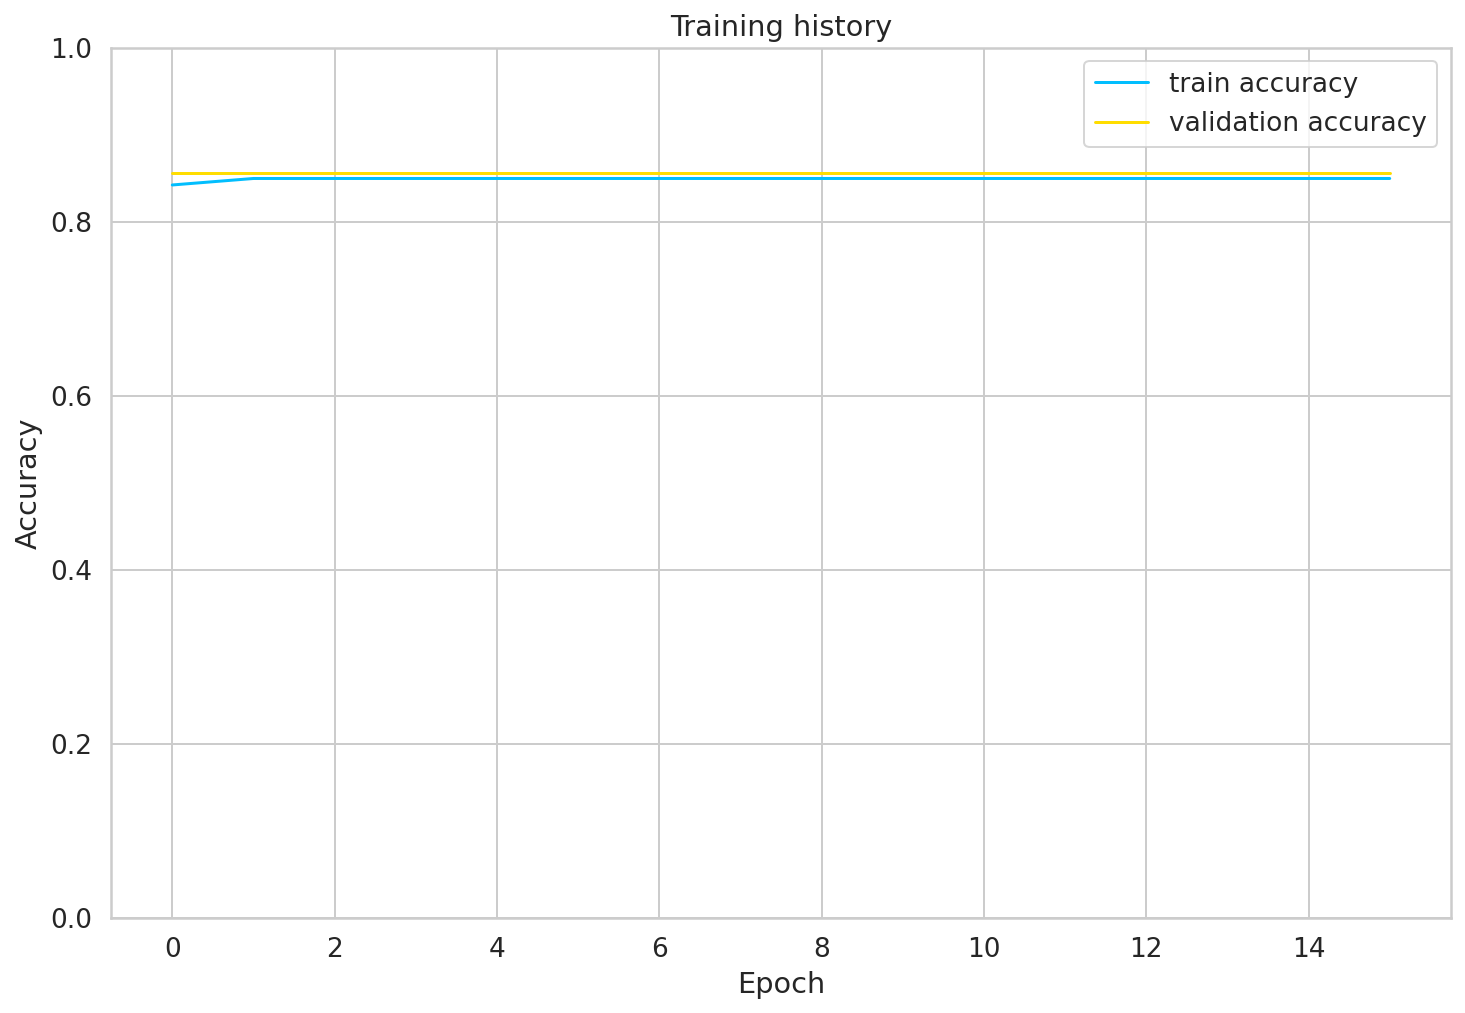

In [35]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(model, test_data_loader,loss_fn,device,len(df_test))
test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            target_1 = d["target_1"].to(device)
            target_2 = d["target_2"].to(device)
            target_3 = d["target_3"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            output_1 = outputs[0].squeeze(1)
            output_2 = outputs[1].squeeze(1)
            output_3 = outputs[2].squeeze(1)
            _, big_idx_1 = torch.max(output_1, dim=1)
            _, big_idx_2 = torch.max(output_2, dim=1)
            _, big_idx_3 = torch.max(output_3, dim=1)
            correct_predictions += torch.sum(big_idx_1 == target_1)
            correct_predictions += torch.sum(big_idx_2 == target_2)
            correct_predictions += torch.sum(big_idx_3 == target_3)

            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

In [ ]:
y_review_texts,y_pred_probs, y_pred, y_test

In [ ]:
a = y_test.numpy

In [ ]:
someListOfLists = list(zip(y_review_texts, y_test, y_pred, y_pred_probs ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['tweet', 'Real', 'Predicted', 'Pred-prob'])
# dff['Real']= pd.to_numeric(df["Real"])
dff

In [ ]:
# class_names, label_dict, possible_labels
# label_dict.keys()
# y_pred


possible_labels_test = df_test.Substance.unique()
possible_labels_test
# label_dict = {}
# for index, possible_label in enumerate(possible_labels):
#     label_dict[possible_label] = index
# label_dict

In [ ]:
print(classification_report(y_test, y_pred, target_names=possible_labels_test))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=possible_labels_test, columns=possible_labels_test)
show_confusion_matrix(df_cm)

In [ ]:
idx = 15
idx = 99

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': possible_labels,
  'values': y_pred_probs[idx]
})
true_sentiment, y_pred[idx]

In [ ]:
pred_df

In [ ]:
# possible_labels,class_names,true_sentiment

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {possible_labels[true_sentiment]}')
print(f'True sentiment category fullname: {class_names[possible_labels[true_sentiment]]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Substance Type')
plt.xlabel('probability')
plt.xlim([0, 1]);

Predicting on Raw Text

In [ ]:
tweet = "Some shots from my shoot for F.I.T. Studio. Coach Fred"
encoded_tweet = tokenizer.encode_plus(
  tweet,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
#   pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)


output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)
print(f'Tweet text: {tweet}')
print(f'Substance type  : {possible_labels[prediction]}')